In [ ]:
import numpy as np
from copy import copy
from scipy.stats import epps_singleton_2samp
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

pvals=[]
for n in tqdm(range(1000)):
    N=1000
    M=10000
    C0=np.zeros((2,3,3,N))
    x0=np.random.rand(2,M)
    #uniform random allele frequency in range (0.1,0.9)
    p=0.01+0.98*np.random.rand()
    x0=(x0>(p**2)).astype(int)+(x0>(p**2+2*p*(1-p))).astype(int)
    p0=np.random.rand(M)
    #uniform random phenotype probability in range (0.1,0.9)
    pheno_q=0.01+0.98*np.random.rand()
    p0=(p0>pheno_q).astype(int)
    pheno=copy(p0)
    for n in range(N):
        np.random.shuffle(p0)
        for i in range(3):
            for j in range(3):
                for k in range(2):
                    C0[k,i,j,n]=np.sum((x0[0]==i)&(x0[1]==j)&(p0==k))

    # sum across first axis to get genotype counts in each
    nij=C0.sum(0).reshape(9,-1).astype(int)
    #nrem[k] is the remaining total genotype counts at the k'th (i,j)
    nrem=np.sum(nij,0)[None,:]-np.cumsum(nij,0)
    #n0 is the total number of zero labels
    n0=C0[0].sum(axis=(0,1)).ravel().astype(int)
    #n0p is the total number of zero labels left to be assigned in the permuted tables
    n0p=copy(n0)
    #initialize "Co" array to store results from our method
    Co=np.zeros(nij.shape)
    for k in range(nij.shape[0]):
        #draw new phenotype labels for each (i,j) from hypergeometric distribution
        Co[k][n0p!=0]=np.random.hypergeometric(nij[k][n0p!=0],nrem[k][n0p!=0],n0p[n0p!=0])
        #subtract the number of labels already assigned to get updated number remaining
        n0p=(n0-np.sum(Co,0)).astype(int)
    #reshape pheno=0 layer of each array back to 1x3x3
    Co=Co.reshape((1,3,3,N))
    #get value-1 labels by subtracting from value-0 labels from total at each (i,j)
    Co=np.vstack([Co,nij.reshape(1,3,3,N)-Co])
    for i in range(3):
        for j in range(3):
            c1,c2=np.vstack([Co[0,i,j,:],C0[0,i,j,:]])
            if not np.all(c1==0):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    try:
                        #note: 
                        pvals.append(epps_singleton_2samp(c1,c2).pvalue)
                    except:
                        pass
pvals=np.array(pvals)


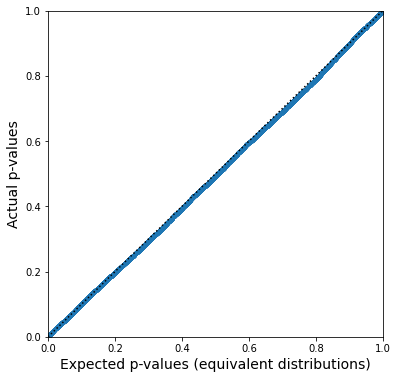

In [48]:
plt.figure(figsize=(6,6))
x=np.linspace(0,1,len(pvals))
plt.plot(x,np.sort(pvals),'.')
plt.plot([0,1],[0,1],':',c=[0,0,0])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Expected p-values (equivalent distributions)',fontsize=14)
plt.ylabel('Actual p-values',fontsize=14)
#plt.savefig('./ES_pvals.png')
#plt.savefig('./ES_pvals.svg')